# Import des modules

In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extractions des données

- SIRH
- Evaluation Performance
- Sondage

In [393]:
sirh = pd.read_csv('ExtraitSIRH.csv')
eval_perf = pd.read_csv('ExtraitEvaluationsPerformance.csv')
sondage = pd.read_csv('ExtraitSondage.csv')

# Création du fichier central

- Identifier les colonnes permettant de réaliser des jointures entre les 3 fichiers :
    - ExtraitSIRH = id_employee
    - ExtraitEvaluationsPerformance = eval_number
    - ExtraitSondage = code_sondage


In [394]:
# Modifier des donnes de la colonne "eval_number" de "eval_perf"
eval_perf['eval_number'] = eval_perf['eval_number'].str.replace('E_', '', regex=False).astype(int)

fc_temp = pd.merge(sirh, eval_perf, left_on="id_employee", right_on="eval_number")
fc = pd.merge(fc_temp, sondage, left_on="id_employee", right_on="code_sondage")
#fc.head(5)

# Traitement des données
- Donnéees Uniques, Redondantes, Erronnées, non valides, etc.


In [395]:
# Données uniques
print(f"Colonnes avec des données uniques: {fc.columns[fc.nunique() == 1].tolist()}")
fc.drop((['nombre_heures_travailless','nombre_employee_sous_responsabilite','ayant_enfants']), axis=1, inplace=True)

# Données redondantes
fc.drop((['eval_number','code_sondage','note_evaluation_actuelle']), axis=1, inplace=True)

# Nom de colonne erronees
fc.rename(columns={'augementation_salaire_precedente': 'augmentation_salaire_precedente'}, inplace=True)
fc.rename(columns={'annee_experience_totale': 'annees_experience_totale'}, inplace=True)

# Données erronees
print(fc.groupby(['statut_marital']).size().sort_values(ascending=False))
for col in fc.select_dtypes(include='object').columns:
    fc[col] = fc[col].str.replace('Ã©', 'e', regex=False)
print(fc.groupby(['statut_marital']).size().sort_values(ascending=False))

# Données non valides
fc['augmentation_salaire_precedente'] = fc['augmentation_salaire_precedente'].str.replace(' %', '', regex=False).astype(int)

Colonnes avec des données uniques: ['nombre_heures_travailless', 'nombre_employee_sous_responsabilite', 'ayant_enfants']
statut_marital
MariÃ©(e)       673
CÃ©libataire    470
DivorcÃ©(e)     327
dtype: int64
statut_marital
Marie(e)       673
Celibataire    470
Divorce(e)     327
dtype: int64


# Analyse Extrait SIRH - Global


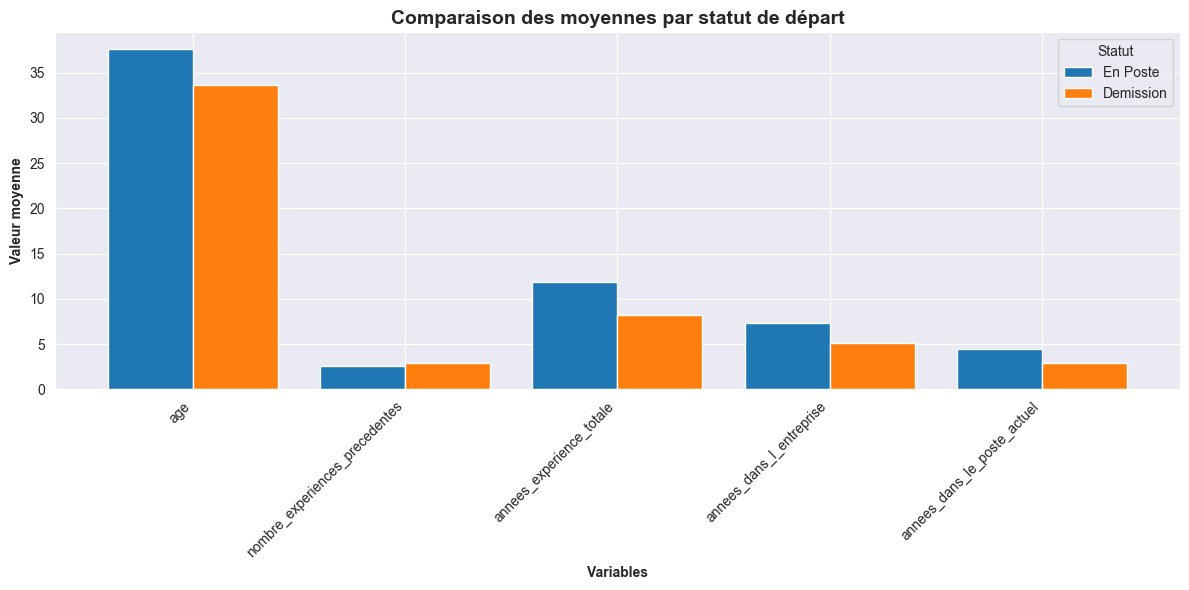

In [396]:
# Liste des colonnes à comparer
colonnes_a_comparer = ['age', 'nombre_experiences_precedentes', 'annees_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel']

# Calculer les moyennes pour chaque colonne par groupe
moyennes = fc.groupby('a_quitte_l_entreprise')[colonnes_a_comparer].mean()

# Transposer pour avoir les variables en index
moyennes_transposed = moyennes.T

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))
moyennes_transposed.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Variables', fontweight='bold')
ax.set_ylabel('Valeur moyenne', fontweight='bold')
ax.set_title('Comparaison des moyennes par statut de départ', fontweight='bold', fontsize=14)
ax.legend(['En Poste', 'Demission'], title="Statut")
ax.set_xticklabels(colonnes_a_comparer, rotation=45, ha='right')

plt.tight_layout()
plt.show()

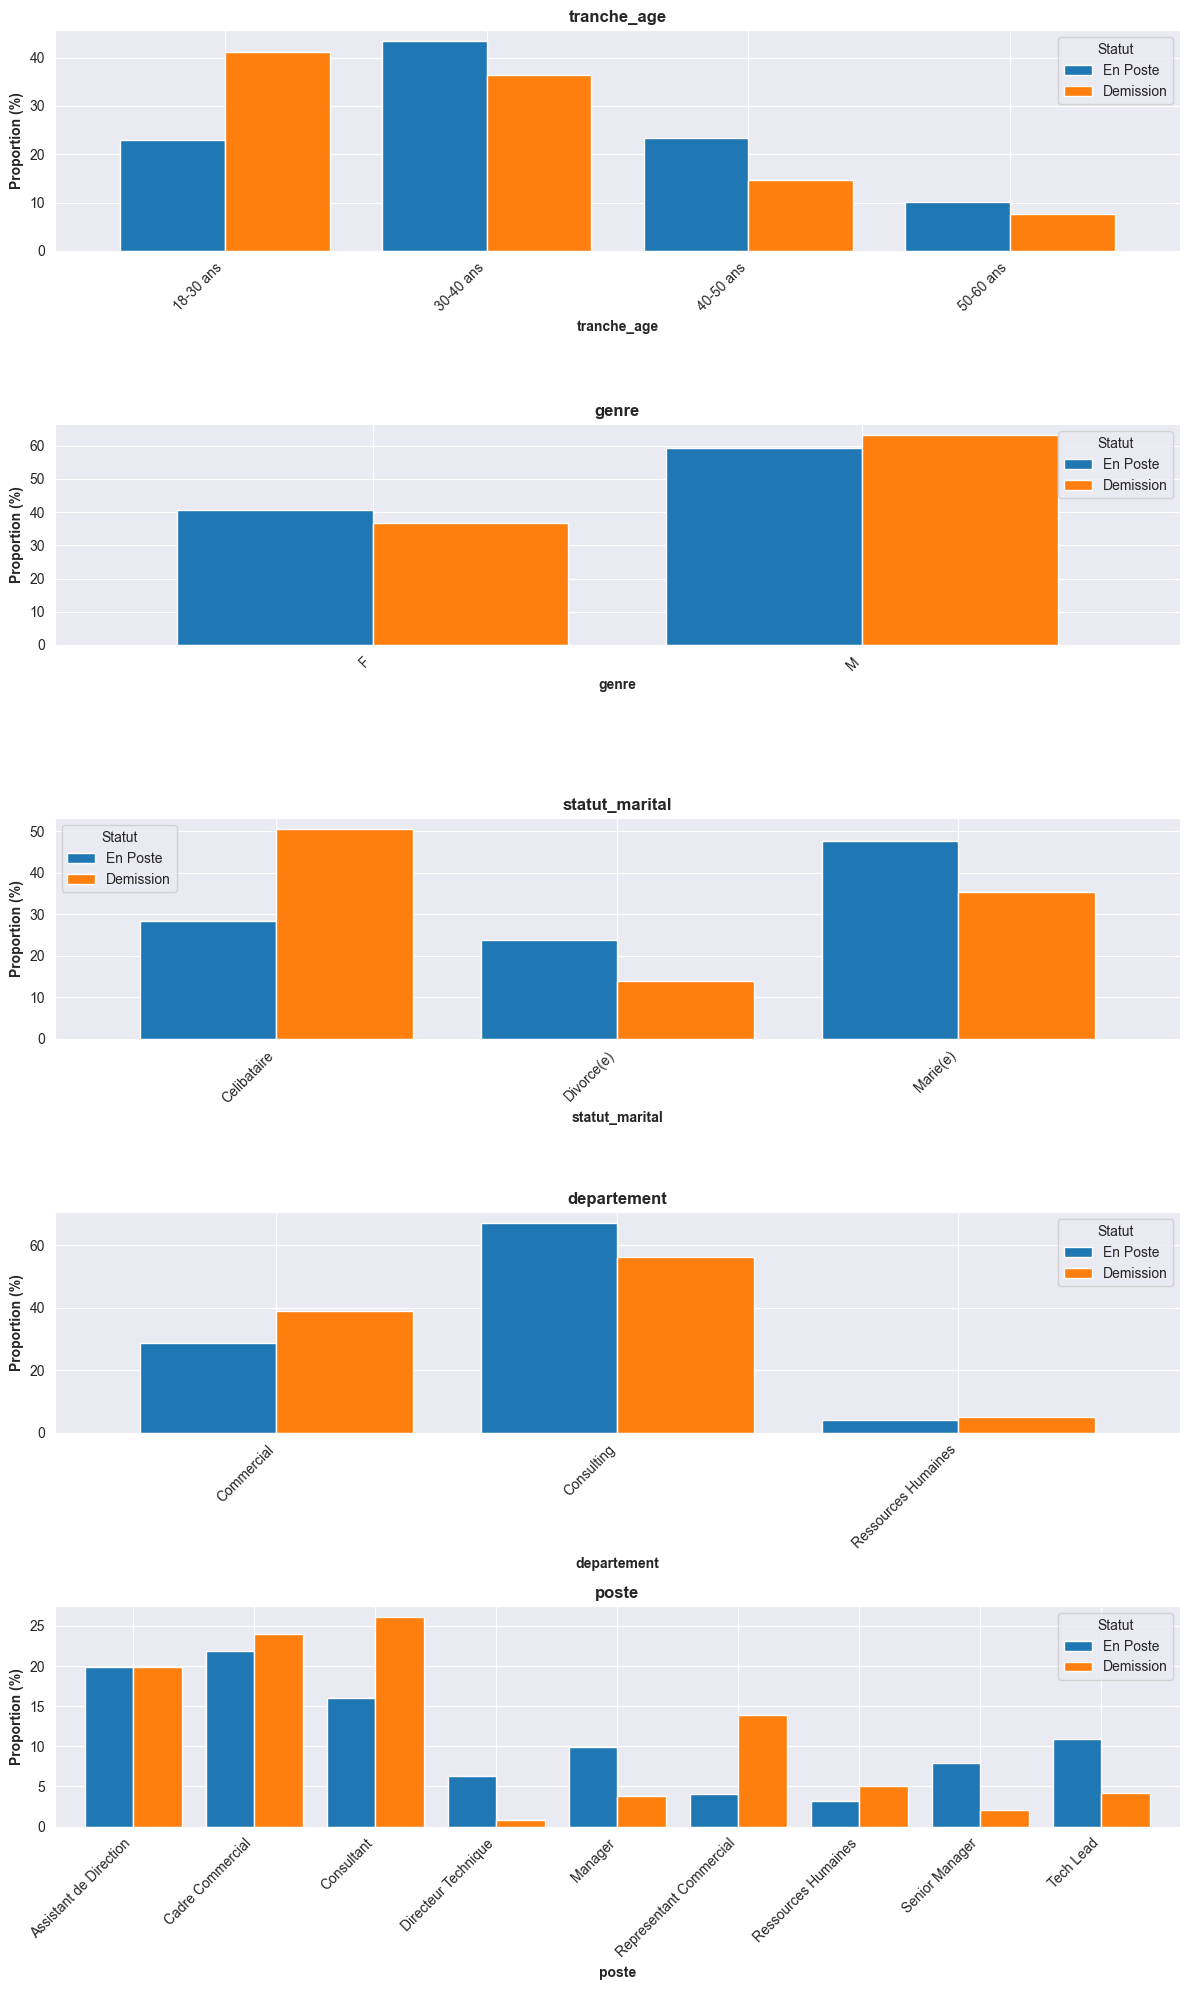

In [397]:
# Créer des tranches
bins = [18, 30, 40, 50, 60]
labels = ['18-30 ans', '30-40 ans', '40-50 ans', '50-60 ans']
fc['tranche_age'] = pd.cut(fc['age'], bins=bins, labels=labels)

# Liste des colonnes catégorielles à comparer
colonnes_categorielles = ['tranche_age', 'genre', 'statut_marital', 'departement', 'poste']

# Calculer les proportions pour chaque catégorie par groupe
proportions_list = []

for col in colonnes_categorielles:
    # Calculer les proportions pour chaque valeur de la variable catégorielle
    prop = fc.groupby(['a_quitte_l_entreprise', col], observed=True).size().unstack(fill_value=0)
    # Normaliser pour avoir des proportions (en %)
    prop = prop.div(prop.sum(axis=1), axis=0) * 100
    proportions_list.append(prop)

# Créer des subplots pour chaque variable catégorielle
fig, axes = plt.subplots(len(colonnes_categorielles), 1, figsize=(12, 4*len(colonnes_categorielles)))

for i, col in enumerate(colonnes_categorielles):
    prop = proportions_list[i]
    prop.T.plot(kind='bar', ax=axes[i], width=0.8)

    axes[i].set_xlabel(col, fontweight='bold')
    axes[i].set_ylabel('Proportion (%)', fontweight='bold')
    axes[i].set_title(f'{col}', fontweight='bold', fontsize=12)
    axes[i].legend(['En Poste', 'Demission'], title="Statut")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

fc.drop((['tranche_age']), axis=1, inplace=True)

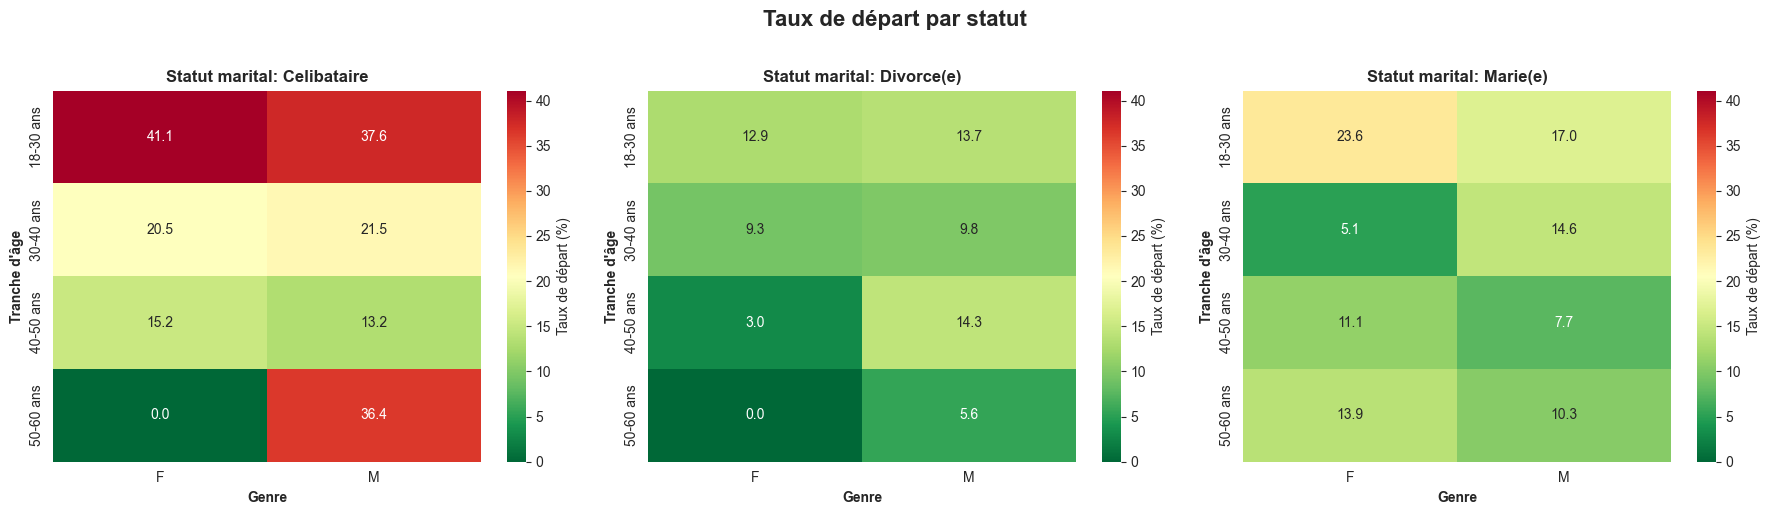

22 employés trouvés.


In [398]:
# Créer des tranches
bins = [18, 30, 40, 50, 60]
labels = ['18-30 ans', '30-40 ans', '40-50 ans', '50-60 ans']
fc['tranche_age'] = pd.cut(fc['age'], bins=bins, labels=labels)

# Convertir 'Oui'/'Non' en 1/0 si nécessaire
if fc['a_quitte_l_entreprise'].dtype == 'object':
    fc['a_quitte_l_entreprise_num'] = fc['a_quitte_l_entreprise'].map({'Oui': 1, 'Non': 0})
else:
    fc['a_quitte_l_entreprise_num'] = fc['a_quitte_l_entreprise']

# Calculer le taux de départ par combinaison de variables
taux_depart = fc.groupby(['tranche_age', 'genre', 'statut_marital'], observed=True).agg({
    'a_quitte_l_entreprise_num': ['sum', 'count']
})
taux_depart.columns = ['departs', 'total']
taux_depart['taux'] = (taux_depart['departs'] / taux_depart['total'] * 100).round(1)
taux_depart = taux_depart.reset_index()

# Créer un pivot pour la heatmap (exemple: Age x Genre, avec statut_marital en facettes)
statuts = sorted(fc['statut_marital'].unique())
fig, axes = plt.subplots(1, len(statuts), figsize=(18, 5))

# Gérer le cas d'un seul statut
if len(statuts) == 1:
    axes = [axes]

for i, statut in enumerate(statuts):
    data_statut = taux_depart[taux_depart['statut_marital'] == statut]
    pivot = data_statut.pivot(index='tranche_age', columns='genre', values='taux')

    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r',
                ax=axes[i], cbar_kws={'label': 'Taux de départ (%)'},
                vmin=0, vmax=taux_depart['taux'].max())

    axes[i].set_title(f'Statut marital: {statut}', fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Genre', fontweight='bold')
    axes[i].set_ylabel('Tranche d\'âge', fontweight='bold')

plt.suptitle('Taux de départ par statut', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Nettoyer
fc.drop(['a_quitte_l_entreprise_num'], axis=1, inplace=True)


subset = fc[
    (fc['genre'] == 'M') &
    (fc['tranche_age'] == '50-60 ans') &
    (fc['statut_marital'] == 'Celibataire')
]
subset.head()
print(f"{len(subset)} employés trouvés.")
subset['a_quitte_l_entreprise'].value_counts(normalize=True) * 100

fc.drop((['tranche_age']), axis=1, inplace=True)

# Analyse Extrait SIRH - Focus Dispersion des Revenus

1. Création des tranches d'expérience
2. Calcul des statistiques par tranche

- **mean** : calcule le revenu moyen dans chaque tranche
- **std** : calcule l'écart-type (dispersion des revenus)

Le coefficient de variation (CV) mesure la dispersion relative :
- Formule : CV = (écart-type / moyenne) × 100
- Plus le CV est élevé, plus les salaires sont hétérogènes dans la tranche
- Permet de comparer la variabilité entre tranches ayant des moyennes différentes

Ce code segmente les employés par ancienneté et analyse la distribution des salaires
dans chaque segment pour identifier où les écarts sont les plus importants.

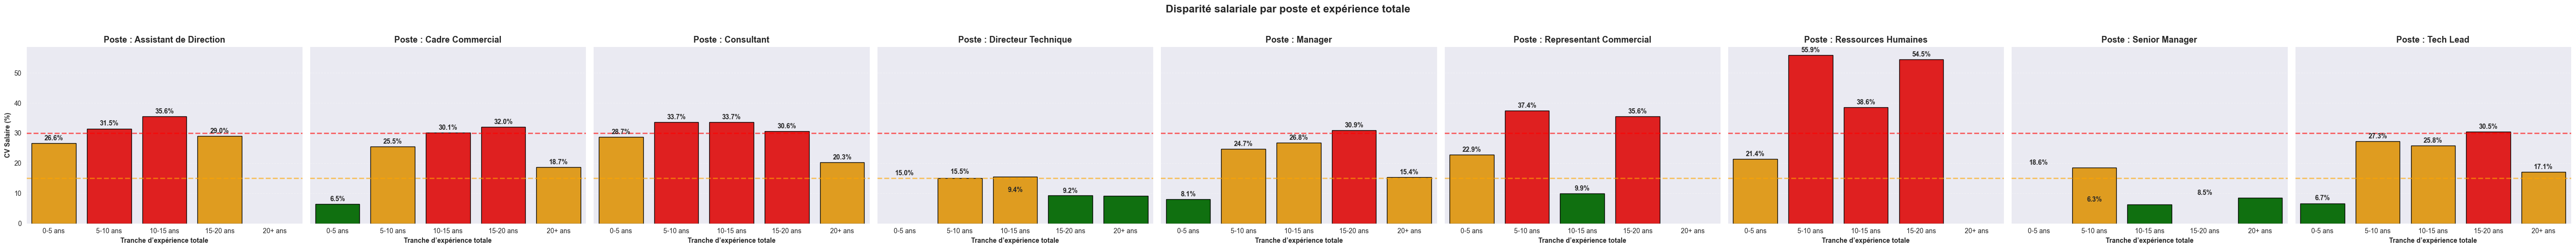

In [399]:
# === Créer les tranches d'expérience totale ===
bins = [0, 5, 10, 15, 20, 100]
labels = ['0-5 ans', '5-10 ans', '10-15 ans', '15-20 ans', '20+ ans']
fc['tranche_experience_totale'] = pd.cut(fc['annees_experience_totale'], bins=bins, labels=labels)

# === Conversion Oui/Non vers 1/0 si besoin ===
if fc['a_quitte_l_entreprise'].dtype == 'object':
    fc['a_quitte_l_entreprise_num'] = fc['a_quitte_l_entreprise'].map({'Oui': 1, 'Non': 0})
else:
    fc['a_quitte_l_entreprise_num'] = fc['a_quitte_l_entreprise']

# === Calcul des stats par poste et tranche d'expérience totale ===
stats_poste_exp = (
    fc.groupby(['poste', 'tranche_experience_totale'], observed=True)['revenu_mensuel']
    .agg(mean='mean', std='std', count='count')
    .round(0)
    .reset_index()
)

# Calcul du coefficient de variation (CV)
stats_poste_exp['cv'] = (stats_poste_exp['std'] / stats_poste_exp['mean'] * 100).round(1)

# === Calcul du nombre de démissions par poste et tranche ===
demissions_poste_exp = (
    fc.groupby(['poste', 'tranche_experience_totale'], observed=True)['a_quitte_l_entreprise_num']
    .sum()
    .reset_index()
)

# === Fusion des deux jeux de données ===
merged = pd.merge(stats_poste_exp, demissions_poste_exp,
                  on=['poste', 'tranche_experience_totale'],
                  how='left')

# === Ajouter une colonne de couleur selon les seuils du CV ===
def get_color(cv):
    if cv < 15:
        return 'green'
    elif cv < 30:
        return 'orange'
    else:
        return 'red'

merged['couleur_cv'] = merged['cv'].apply(get_color)

# === Visualisation ===
postes = merged['poste'].unique()
fig, axes = plt.subplots(1, len(postes), figsize=(6 * len(postes), 5), sharey=True)

if len(postes) == 1:
    axes = [axes]

for ax, poste in zip(axes, postes):
    data_poste = merged[merged['poste'] == poste]

    sns.barplot(
        data=data_poste,
        x='tranche_experience_totale',
        y='cv',
        hue='couleur_cv',
        palette={'green': 'green', 'orange': 'orange', 'red': 'red'},
        dodge=False,
        legend=False,
        ax=ax,
        edgecolor='black'
    )

    # Ajouter les valeurs sur les barres
    for i, val in enumerate(data_poste['cv']):
        ax.text(i, val + 0.5, f'{val:.1f}%', ha='center', va='bottom',
                fontsize=10, fontweight='bold')

    ax.set_title(f'Poste : {poste}', fontweight='bold', fontsize=13)
    ax.set_xlabel('Tranche d’expérience totale', fontweight='bold')
    ax.set_ylabel('CV Salaire (%)', fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.axhline(y=15, color='orange', linestyle='--', alpha=0.6, linewidth=2)
    ax.axhline(y=30, color='red', linestyle='--', alpha=0.6, linewidth=2)

plt.suptitle('Disparité salariale par poste et expérience totale', fontweight='bold', fontsize=16, y=1.03)
plt.tight_layout()
plt.savefig('images/disparite_cv_poste_experience_totale.png', dpi=300, bbox_inches='tight')
plt.show()

# Nettoyage
fc.drop(['tranche_experience_totale', 'a_quitte_l_entreprise_num'], axis=1, inplace=True)

# Analyse Extrait Sondage - Global

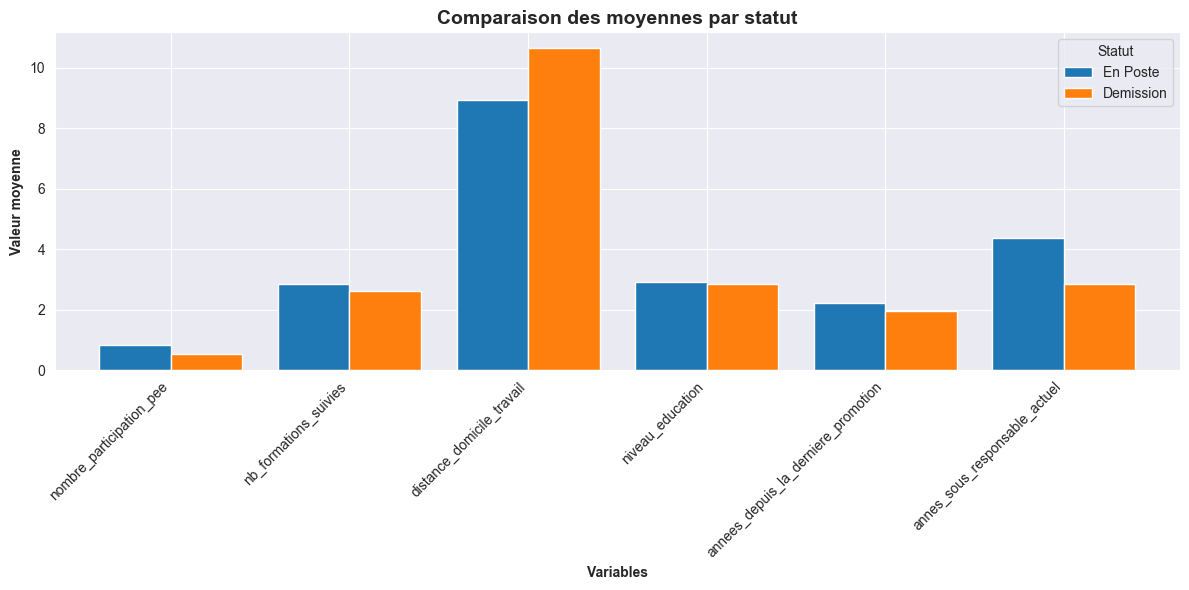

In [400]:
# Liste des colonnes à comparer
colonnes_a_comparer = ['nombre_participation_pee','nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel' ]

# Calculer les moyennes pour chaque colonne par groupe
moyennes = fc.groupby('a_quitte_l_entreprise')[colonnes_a_comparer].mean()

# Transposer pour avoir les variables en index
moyennes_transposed = moyennes.T

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))
moyennes_transposed.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Variables', fontweight='bold')
ax.set_ylabel('Valeur moyenne', fontweight='bold')
ax.set_title('Comparaison des moyennes par statut', fontweight='bold', fontsize=14)
ax.legend(['En Poste', 'Demission'], title="Statut")
ax.set_xticklabels(colonnes_a_comparer, rotation=45, ha='right')

plt.tight_layout()
plt.show()

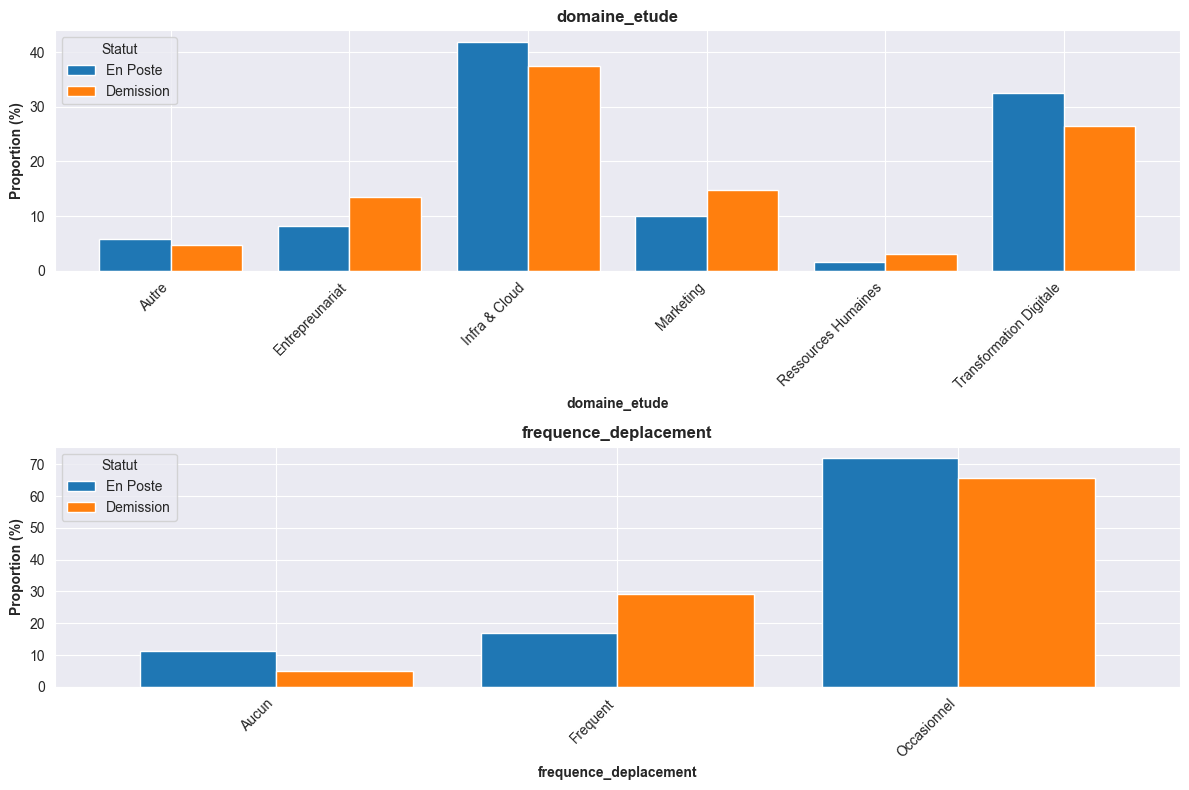

In [401]:
# Liste des colonnes catégorielles à comparer
colonnes_categorielles = ['domaine_etude', 'frequence_deplacement']

# Calculer les proportions pour chaque catégorie par groupe
proportions_list = []

for col in colonnes_categorielles:
    # Calculer les proportions pour chaque valeur de la variable catégorielle
    prop = fc.groupby(['a_quitte_l_entreprise', col]).size().unstack(fill_value=0)
    # Normaliser pour avoir des proportions (en %)
    prop = prop.div(prop.sum(axis=1), axis=0) * 100
    proportions_list.append(prop)

# Créer des subplots pour chaque variable catégorielle
fig, axes = plt.subplots(len(colonnes_categorielles), 1, figsize=(12, 4*len(colonnes_categorielles)))

for i, col in enumerate(colonnes_categorielles):
    prop = proportions_list[i]
    prop.T.plot(kind='bar', ax=axes[i], width=0.8)

    axes[i].set_xlabel(col, fontweight='bold')
    axes[i].set_ylabel('Proportion (%)', fontweight='bold')
    axes[i].set_title(f'{col}', fontweight='bold', fontsize=12)
    axes[i].legend(['En Poste', 'Demission'], title="Statut")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Analyse Extrait Evaluations Performances - Global


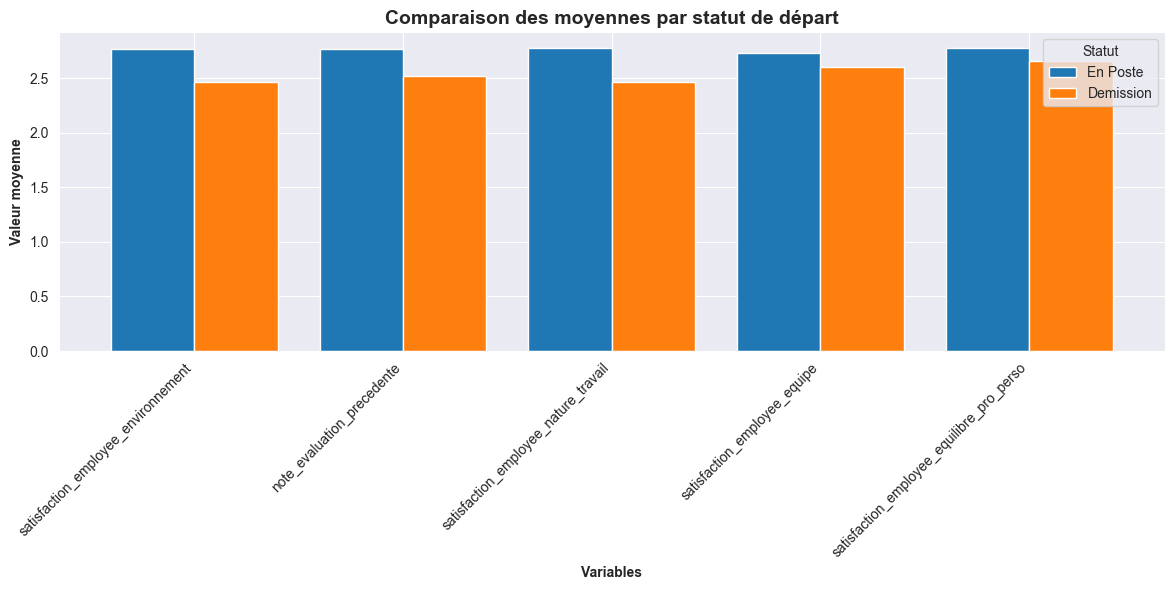

In [402]:
# Liste des colonnes à comparer
colonnes_a_comparer = ['satisfaction_employee_environnement','note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso']

# Calculer les moyennes pour chaque colonne par groupe
moyennes = fc.groupby('a_quitte_l_entreprise')[colonnes_a_comparer].mean()

# Transposer pour avoir les variables en index
moyennes_transposed = moyennes.T

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))
moyennes_transposed.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Variables', fontweight='bold')
ax.set_ylabel('Valeur moyenne', fontweight='bold')
ax.set_title('Comparaison des moyennes par statut de départ', fontweight='bold', fontsize=14)
ax.legend(['En Poste', 'Demission'], title="Statut")
ax.set_xticklabels(colonnes_a_comparer, rotation=45, ha='right')

plt.tight_layout()
plt.show()

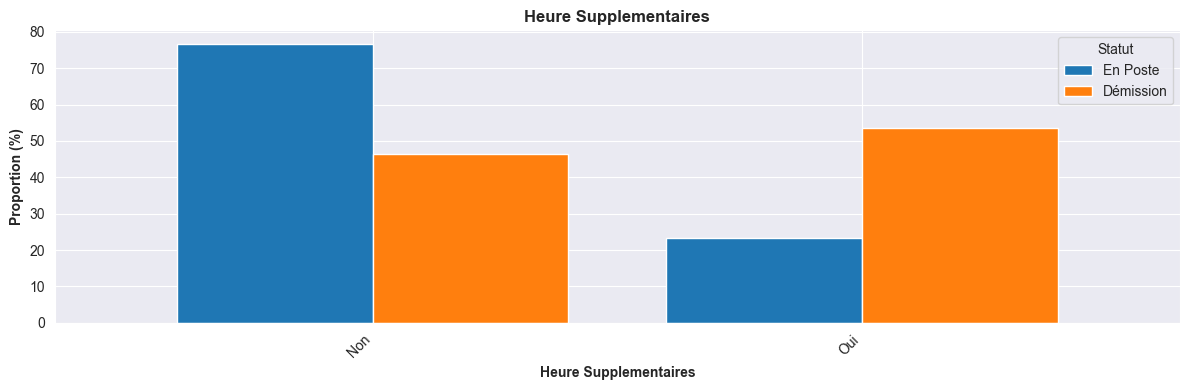

In [403]:
# Liste des colonnes catégorielles à comparer
colonnes_categorielles = ['heure_supplementaires']

# Calculer les proportions pour chaque catégorie par groupe
proportions_list = []

for col in colonnes_categorielles:
    # Calculer les proportions pour chaque valeur de la variable catégorielle
    prop = fc.groupby(['a_quitte_l_entreprise', col], observed=True).size().unstack(fill_value=0)
    # Normaliser pour avoir des proportions (en %)
    prop = prop.div(prop.sum(axis=1), axis=0) * 100
    proportions_list.append(prop)

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 4))

col = colonnes_categorielles[0]
prop = proportions_list[0]
prop.T.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel(col.replace('_', ' ').title(), fontweight='bold')
ax.set_ylabel('Proportion (%)', fontweight='bold')
ax.set_title(f'{col.replace("_", " ").title()}', fontweight='bold', fontsize=12)
ax.legend(['En Poste', 'Démission'], title="Statut")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Analyse sur l'ensemble du dataset
- Identifier le profil type d'un salarié qui a démissioné

# Export CSV

In [404]:
fc.to_csv('fc.csv', index=False)